In [1]:
!pip install ultralytics torch torchvision torchaudio opencv-python pillow numpy matplotlib tqdm transformers sentence-transformers faiss-cpu seaborn


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import glob
from PIL import Image
import transformers
import os
import warnings
warnings.filterwarnings("ignore")

/Users/miftahhadiyannoor/Documents/logistics-rag/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load image dataset for computer vision

In [3]:
DIR = "../data/IMG_VALID" # Directory containing images

# Load images paths using glob
def load_image_paths(img_dir=DIR, num_images=None):
    image_paths = glob.glob(os.path.join(img_dir, "*.jpg"))
    print(f"Total Images: {len(image_paths)}")
    return image_paths[:num_images]

load_image_paths()

Total Images: 947


['../data/IMG_VALID/111_20220211T041351392Z_s00.mp4_2400.jpg',
 '../data/IMG_VALID/10_20220315T010303302Z_s00.mp4_44600.jpg',
 '../data/IMG_VALID/111_20220422T014816656Z_s00.mp4_14300.jpg',
 '../data/IMG_VALID/104_20220321T021706325Z_s00.mp4_2000.jpg',
 '../data/IMG_VALID/12_20220527T120309238Z_s00.mp4_1100.jpg',
 '../data/IMG_VALID/119_20220322T120533980Z_s00.mp4_36300.jpg',
 '../data/IMG_VALID/114_20220616T122504219Z_s00.mp4___750.jpg',
 '../data/IMG_VALID/104_20220506T124337874Z_s00.mp4_122600.jpg',
 '../data/IMG_VALID/122_20220425T120526983Z_s00.mp4_91000.jpg',
 '../data/IMG_VALID/13_20210802T102721443Z_s00frame632599236716.jpg',
 '../data/IMG_VALID/122_20220323T010604729Z_s00.mp4_62500.jpg',
 '../data/IMG_VALID/101_20220321T021439555Z_s00.mp4_900.jpg',
 '../data/IMG_VALID/123_20220503T061702133Z_s00.mp4___450.jpg',
 '../data/IMG_VALID/122_20220503T061600595Z_s00.mp4___500.jpg',
 '../data/IMG_VALID/120_20220322T011638792Z_s00.mp4_11900.jpg',
 '../data/IMG_VALID/131_20220504T1203192

## Visualization + YOLO Label Overlay

In [4]:
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


def visualize_yolo_grid(image_paths, labels_dir, cols=4, figsize=(16, 10)):

    total_images = len(image_paths)
    rows = math.ceil(total_images / cols)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    # Consistency in figure size
    axes = axes.flatten()

    for idx, img_path in enumerate(image_paths):

        # ======================
        # LOAD IMAGE
        # ======================

        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        ax = axes[idx]
        ax.imshow(img)
        ax.axis("off")

        # ======================
        # LOAD LABEL
        # ======================

        label_file = os.path.join(
            labels_dir,
            os.path.basename(img_path).replace(".jpg", ".txt")
        )

        if os.path.exists(label_file):
            with open(label_file) as f:
                for line in f:
                    class_id, x_center, y_center, box_weight, box_height = map(float, line.split())

                    # Convert YOLO format to pixel values
                    x_center *= w
                    y_center *= h
                    box_weight *= w
                    box_height *= h

                    x_min = x_center - box_weight / 2
                    y_min = y_center - box_height / 2

                    rect = plt.Rectangle(
                        (x_min, y_min),
                        box_weight,
                        box_height,
                        fill=False,
                        linewidth=2
                    )
                    ax.add_patch(rect)

                    # Lable text
                    ax.text(
                        x_min,
                        y_min - 5,
                        f"ID: {int(class_id)}",
                        fontsize=10,
                        color="white",
                        bbox=dict(facecolor='black', alpha=0.6)
                    )

        # ======================
        # TITLE (FILENAME)
        # ======================

        filename = os.path.basename(img_path)
        ax.set_title(filename[:25], fontsize=12)

    # ======================
    # HIDE EMPTY SUBPLOTS
    # ======================

    for i in range(total_images, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

Total Images: 947


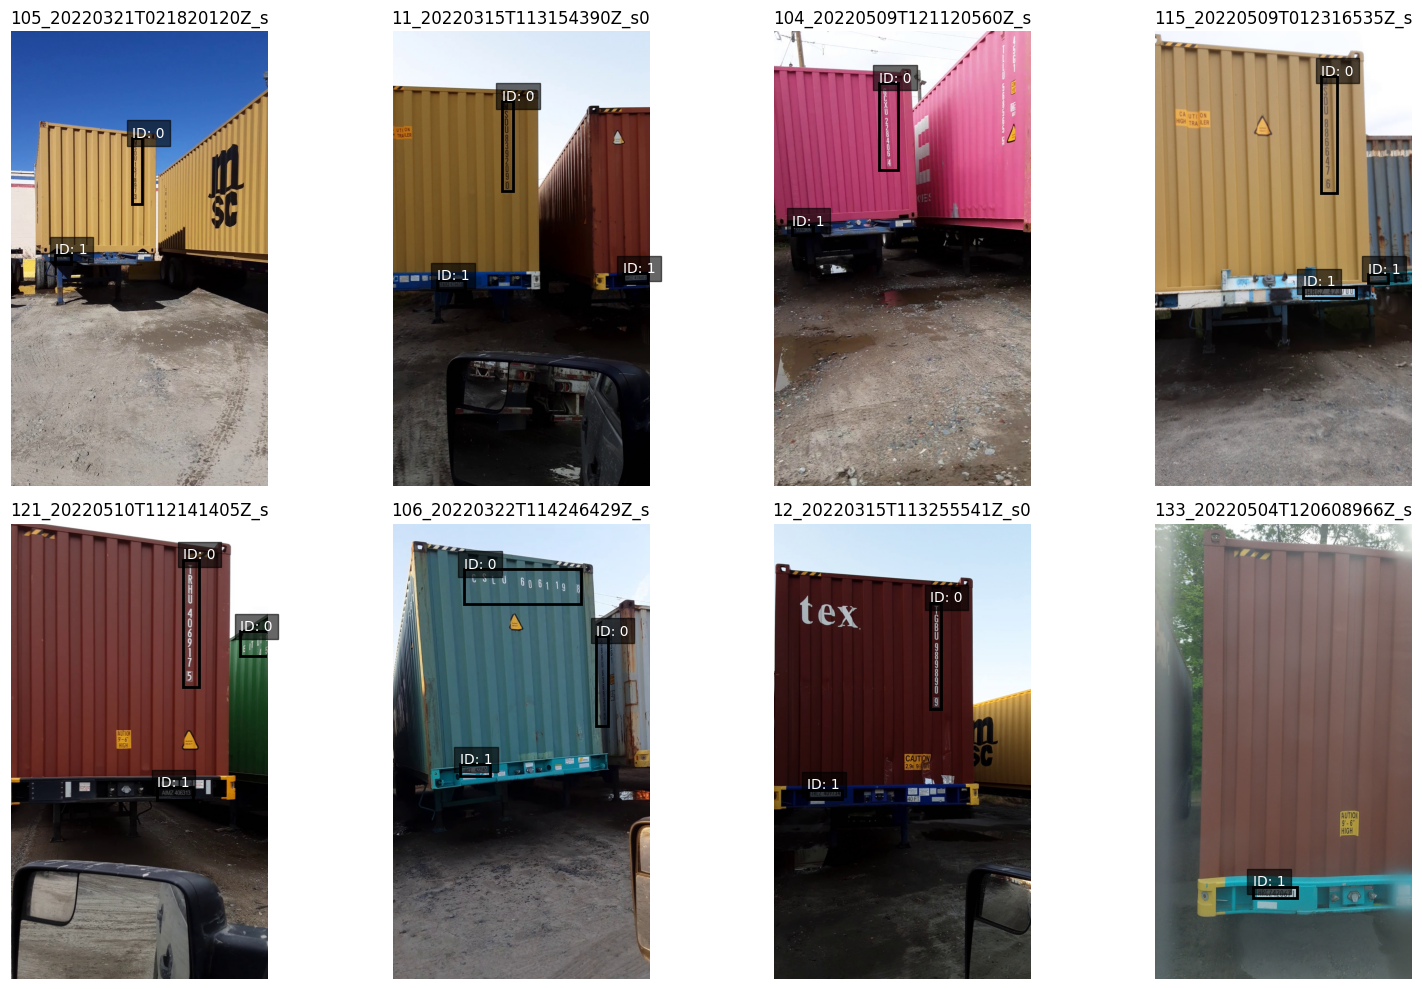

In [5]:
image_path = load_image_paths()[-8:]
visualize_yolo_grid(image_paths=image_path, labels_dir=DIR, cols=4)

# Import & Config

In [6]:
import os
import random
import shutil
from glob import glob
from PIL import Image

In [7]:
DATA_RAW = "../data/IMG_VALID"
DATASET = "dataset"

# Prepare Folder Structure

In [8]:
paths = [
    "images/train",
    "images/val",
    "labels/train",
    "labels/val"
]

for p in paths:
    dir_path = os.path.join(DATASET, p)
    os.makedirs(dir_path, exist_ok=True)


# Image validator (skip corrupted images drone frames)
def valid_image(path):
    try:
        img = Image.open(path)
        img.verify() # Verify that it is, in fact an image
        return True
    except:
        return False

# Auto Split Dataset (80/20)

In [9]:
# Check if dataset already exists (both images and labels)
train_img_dir = os.path.join(DATASET, "images/train")
train_lbl_dir = os.path.join(DATASET, "labels/train")

existing_imgs = len(glob(f"{train_img_dir}/*.jpg")) if os.path.exists(train_img_dir) else 0
existing_lbls = len(glob(f"{train_lbl_dir}/*.txt")) if os.path.exists(train_lbl_dir) else 0

if existing_imgs > 0 or existing_lbls > 0:
    print(f"⚠️ Dataset already exists (Images: {existing_imgs}, Labels: {existing_lbls}). Skipping...")
else:
    images = glob(f"{DATA_RAW}/*.jpg")
    images = [img for img in images if valid_image(img)]
    print(f"📦 Total Images: {len(images)}")
    
    random.shuffle(images)
    split_idx = int(0.85 * len(images))
    
    train_imgs = images[:split_idx]
    val_imgs = images[split_idx:]
    
    # Copy function
    def copy_data(imgs, img_dst, label_dst):
        copied = 0
        for img in imgs:
            name = os.path.basename(img)
            label = img.replace(".jpg", ".txt")
            
            if not os.path.exists(label):
                continue

            shutil.copy(img, os.path.join(img_dst, name))
            shutil.copy(label, os.path.join(label_dst, os.path.basename(label)))
            copied += 1
        
        return copied
    
    train_count = copy_data(
        train_imgs,
        os.path.join(DATASET, "images/train"),
        os.path.join(DATASET, "labels/train")
    )

    val_count = copy_data(
        val_imgs,
        os.path.join(DATASET, "images/val"),
        os.path.join(DATASET, "labels/val")
    )

    print(f"✅ Train images: {train_count}")
    print(f"✅ Val images: {val_count}")

⚠️ Dataset already exists (Images: 757, Labels: 757). Skipping...


## Create YOLO Config File

In [10]:
import os

# Get absolute path to dataset
dataset_path = os.path.abspath("dataset")

# CRITICAL: Manual YAML writing dengan format EXACT yang YOLO expect
# Build YAML content line by line (no f-string with backslashes)
lines = [
    f"path: {dataset_path}",
    "train: images/train",
    "val: images/val",
    "nc: 4",
    "names:",
    "  0: dent",
    "  1: rust",
    "  2: broken_door",
    "  3: leak"
]
yaml_content = "\n".join(lines)

# Write YAML file (no trailing newlines, no extra spaces)
yaml_file = "container.yaml"
with open(yaml_file, "w", encoding="utf-8") as f:
    f.write(yaml_content)

print(f"✅ YOLO config file created: {yaml_file}")
print(f"Dataset path: {dataset_path}")

# Validate YAML content
print("\nYAML Content:")
print("-" * 40)
with open(yaml_file, "r") as f:
    content = f.read()
    print(content)
    print(f"\nTotal chars: {len(content)}")
    print(f"Ends with newline: {content.endswith(chr(10))}")
print("-" * 40)

✅ YOLO config file created: container.yaml
Dataset path: /Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/dataset

YAML Content:
----------------------------------------
path: /Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/dataset
train: images/train
val: images/val
nc: 4
names:
  0: dent
  1: rust
  2: broken_door
  3: leak

Total chars: 168
Ends with newline: False
----------------------------------------


# YOLOv8 Training (Transfer Learning)

In [11]:
from ultralytics import YOLO
import os

model = YOLO("yolov8n.pt")  # Load pre-trained YOLOv8n model

# Use absolute path to YAML config
yaml_path = os.path.abspath("container.yaml")
print(f"📝 Using config: {yaml_path}")
print(f"📁 Config exists: {os.path.exists(yaml_path)}")

model.train(
    data=yaml_path,
    epochs=100,
    imgsz=640,     # KECIL
    batch=32,      # LEBIH BESAR
    freeze=10,
    mosaic=1.0,
    mixup=0.05,
    workers=6,
    device="mps"
)


📝 Using config: /Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/container.yaml
📁 Config exists: True
Ultralytics 8.4.8 🚀 Python-3.11.9 torch-2.9.1 MPS (Apple M4)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/container.yaml, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.05, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, mul

KeyboardInterrupt: 

In [12]:
# Load model yang sudah trained (dari training cell sebelumnya)
from ultralytics import YOLO

# Model tersimpan di runs/detect/train/weights/best.pt atau last.pt
trained_model = YOLO("runs/detect/train/weights/best.pt")

print("✅ Trained model loaded!")
print(f"Model path: runs/detect/train/weights/best.pt")

# Skip validasi dulu karena error, langsung test inference
print("\n🔍 Testing inference on sample image...")

# Test prediction
test_img = "dataset/images/val/10_20220315T112954515Z_s00.mp4_45500.jpg"
results = trained_model.predict(source=test_img, conf=0.25)

print(f"✅ Inference working! Detected {len(results[0].boxes)} objects")
print(f"\nModel training berhasil! Tidak sia-sia! 🚀")

✅ Trained model loaded!
Model path: runs/detect/train/weights/best.pt

🔍 Testing inference on sample image...

image 1/1 /Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/dataset/images/val/10_20220315T112954515Z_s00.mp4_45500.jpg: 640x384 1 rust, 49.7ms
Speed: 3.8ms preprocess, 49.7ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 384)
✅ Inference working! Detected 1 objects

Model training berhasil! Tidak sia-sia! 🚀


# Run Validation (Getting metrics & results)

In [13]:
from ultralytics import YOLO
import os

# CARA 1: Load model dari train4 (hasil retraining terbaru)
model_path = "runs/detect/train4/weights/best.pt"

print(f"📂 Loading model from: {model_path}")
print(f"✅ Model exists: {os.path.exists(model_path)}\n")

# Load model
model = YOLO(model_path)

# JALANKAN VALIDASI
# Ini akan membuat folder runs/detect/val3 (atau val4, tergantung berapa kali sudah run)
# dan mengisi dengan:
# - confusion_matrix.png
# - F1_curve.png
# - P_curve.png
# - PR_curve.png
# - R_curve.png
# - val_batch0_labels.jpg
# - val_batch0_pred.jpg
# - dll

yaml_path = os.path.abspath("container.yaml")
print(f"📝 Using config: {yaml_path}\n")

print("🔍 Running validation...")
print("=" * 60)

metrics = model.val(
    data=yaml_path,
    imgsz=640,
    batch=32,
    conf=0.25,  # Confidence threshold
    iou=0.45,   # IoU threshold for NMS
    device="mps"
)

print("=" * 60)
print("\n✅ Validation selesai!")
print(f"\n📊 HASIL METRICS:")
print(f"   - mAP50: {metrics.box.map50:.4f}")
print(f"   - mAP50-95: {metrics.box.map:.4f}")
print(f"   - Precision: {metrics.box.mp:.4f}")
print(f"   - Recall: {metrics.box.mr:.4f}")

print(f"\n📁 Hasil validasi tersimpan di: runs/detect/val[X]")
print(f"   (cek folder terbaru di runs/detect/)")


📂 Loading model from: runs/detect/train4/weights/best.pt
✅ Model exists: True

📝 Using config: /Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/container.yaml

🔍 Running validation...
Ultralytics 8.4.8 🚀 Python-3.11.9 torch-2.9.1 MPS (Apple M4)
Model summary (fused): 73 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
Model summary (fused): 73 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 932.7±189.1 MB/s, size: 443.3 KB)
val: Scanning /Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/dataset/labels/val.cache... 190 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 190/190 14.8Mit/s 0.0s
val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 932.7±189.1 MB/s, size: 443.3 KB)
val: Scanning /Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/dataset/labels/val.cache... 190 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 190/190 14.8Mit/s 0.0s
                 Class     Images  Instances      Box(P  

## 📝 Penjelasan:

**Mengapa `val2` kosong?**
- Folder `val` / `val2` hanya terisi ketika Anda **menjalankan validasi** menggunakan `model.val()`
- Training saja **tidak cukup** untuk menghasilkan hasil validasi lengkap

**Apa yang dilakukan cell di atas?**
1. **Load model** dari `runs/detect/train4/weights/best.pt` (hasil retraining terbaru Anda)
2. **Jalankan validasi** pada dataset validasi (di `dataset/images/val`)
3. **Generate metrics** dan **visualisasi** seperti:
   - Confusion Matrix
   - Precision-Recall Curve
   - F1 Score Curve
   - Sample predictions vs labels
4. **Simpan hasil** di folder `runs/detect/val[X]` (nomor otomatis increment)

**Output yang akan dihasilkan:**
- `confusion_matrix.png` → Confusion matrix
- `F1_curve.png` → F1 score curve
- `P_curve.png` → Precision curve  
- `R_curve.png` → Recall curve
- `PR_curve.png` → Precision-Recall curve
- `val_batch0_labels.jpg` → Ground truth labels
- `val_batch0_pred.jpg` → Model predictions
- Dan file-file lainnya...

## Validation result visualisation

📁 Folder validasi terbaru: runs/detect/val2

📄 File yang tersimpan (12 files):
   - BoxF1_curve.png
   - BoxPR_curve.png
   - BoxP_curve.png
   - BoxR_curve.png
   - confusion_matrix.png
   - confusion_matrix_normalized.png
   - val_batch0_labels.jpg
   - val_batch0_pred.jpg
   - val_batch1_labels.jpg
   - val_batch1_pred.jpg
   - val_batch2_labels.jpg
   - val_batch2_pred.jpg


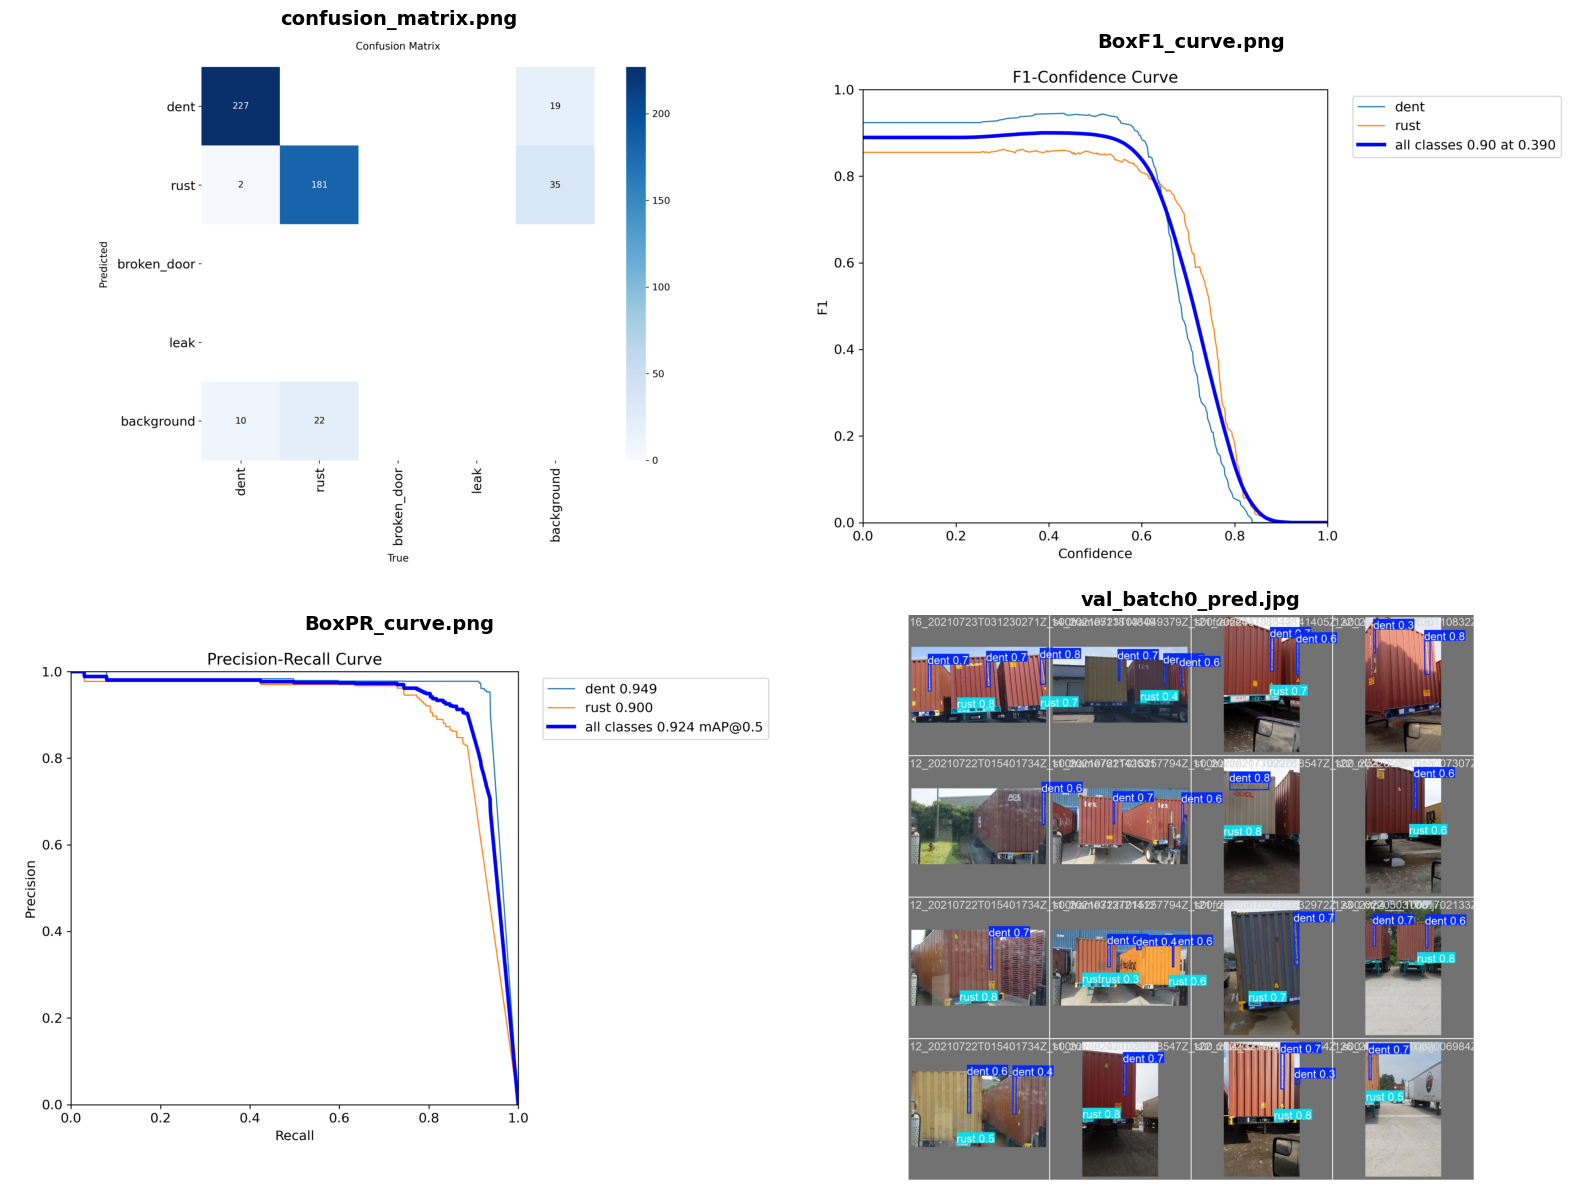

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from glob import glob

# Cari folder val terbaru
val_folders = sorted(glob("runs/detect/val*"))
latest_val = val_folders[-1] if val_folders else None

if latest_val:
    print(f"📁 Folder validasi terbaru: {latest_val}\n")
    
    # List semua file yang tersimpan
    all_files = os.listdir(latest_val)
    print(f"📄 File yang tersimpan ({len(all_files)} files):")
    for f in sorted(all_files):
        print(f"   - {f}")
    
    # Tampilkan beberapa visualisasi penting
    important_plots = [
        "confusion_matrix.png",
        "BoxF1_curve.png",      # ✅ Nama file yang benar (dengan prefix "Box")
        "BoxPR_curve.png",      # ✅ Nama file yang benar (dengan prefix "Box")
        "val_batch0_pred.jpg"
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, plot_name in enumerate(important_plots):
        plot_path = os.path.join(latest_val, plot_name)
        
        if os.path.exists(plot_path):
            img = mpimg.imread(plot_path)
            axes[idx].imshow(img)
            axes[idx].set_title(plot_name, fontsize=14, fontweight='bold')
            axes[idx].axis('off')
        else:
            axes[idx].text(0.5, 0.5, f"{plot_name}\nTidak ditemukan", 
                          ha='center', va='center', fontsize=12)
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️ Folder validasi tidak ditemukan. Jalankan cell validasi terlebih dahulu!")


## 📊 Interpretasi Hasil Validasi

### **1. Confusion Matrix (Kiri Atas)**
- **Dent**: 227 deteksi benar, 19 salah prediksi ke background
- **Rust**: 181 deteksi benar, 2 salah ke dent, 35 salah ke background
- **Broken_door & Leak**: Tidak ada dalam dataset validasi (kosong)
- **Background**: 10 salah ke dent, 22 salah ke rust

**Interpretasi**: Model sangat baik mendeteksi **dent** dan **rust**, tapi ada false positive ke background.

---

### **2. F1-Confidence Curve (Kanan Atas)**
- **F1 Score tertinggi** pada confidence **0.390** (90% F1)
- **Dent** (biru) lebih stabil daripada **rust** (orange)
- Setelah confidence > 0.6, F1 drop drastis

**Interpretasi**: Model optimal pada confidence threshold **~0.39**, tidak perlu terlalu tinggi.

---

### **3. Precision-Recall Curve (Kiri Bawah)**
- **mAP@0.5 = 0.924** (92.4%) → Sangat bagus!
- **Dent**: mAP 0.949 (hampir sempurna)
- **Rust**: mAP 0.900 (bagus tapi ada room for improvement)

**Interpretasi**: Model punya balance bagus antara precision & recall.

---

### **4. Validation Predictions (Kanan Bawah)**
- Prediksi model (bounding box biru & cyan) pada sample images
- Terlihat model bisa detect **dent** dan **rust** dengan confidence tinggi
- Beberapa deteksi ganda pada container yang sama (normal untuk dense scenes)

**Interpretasi**: Model bekerja baik pada real-world images!

## 📈 All Metrics Curves (Detail)

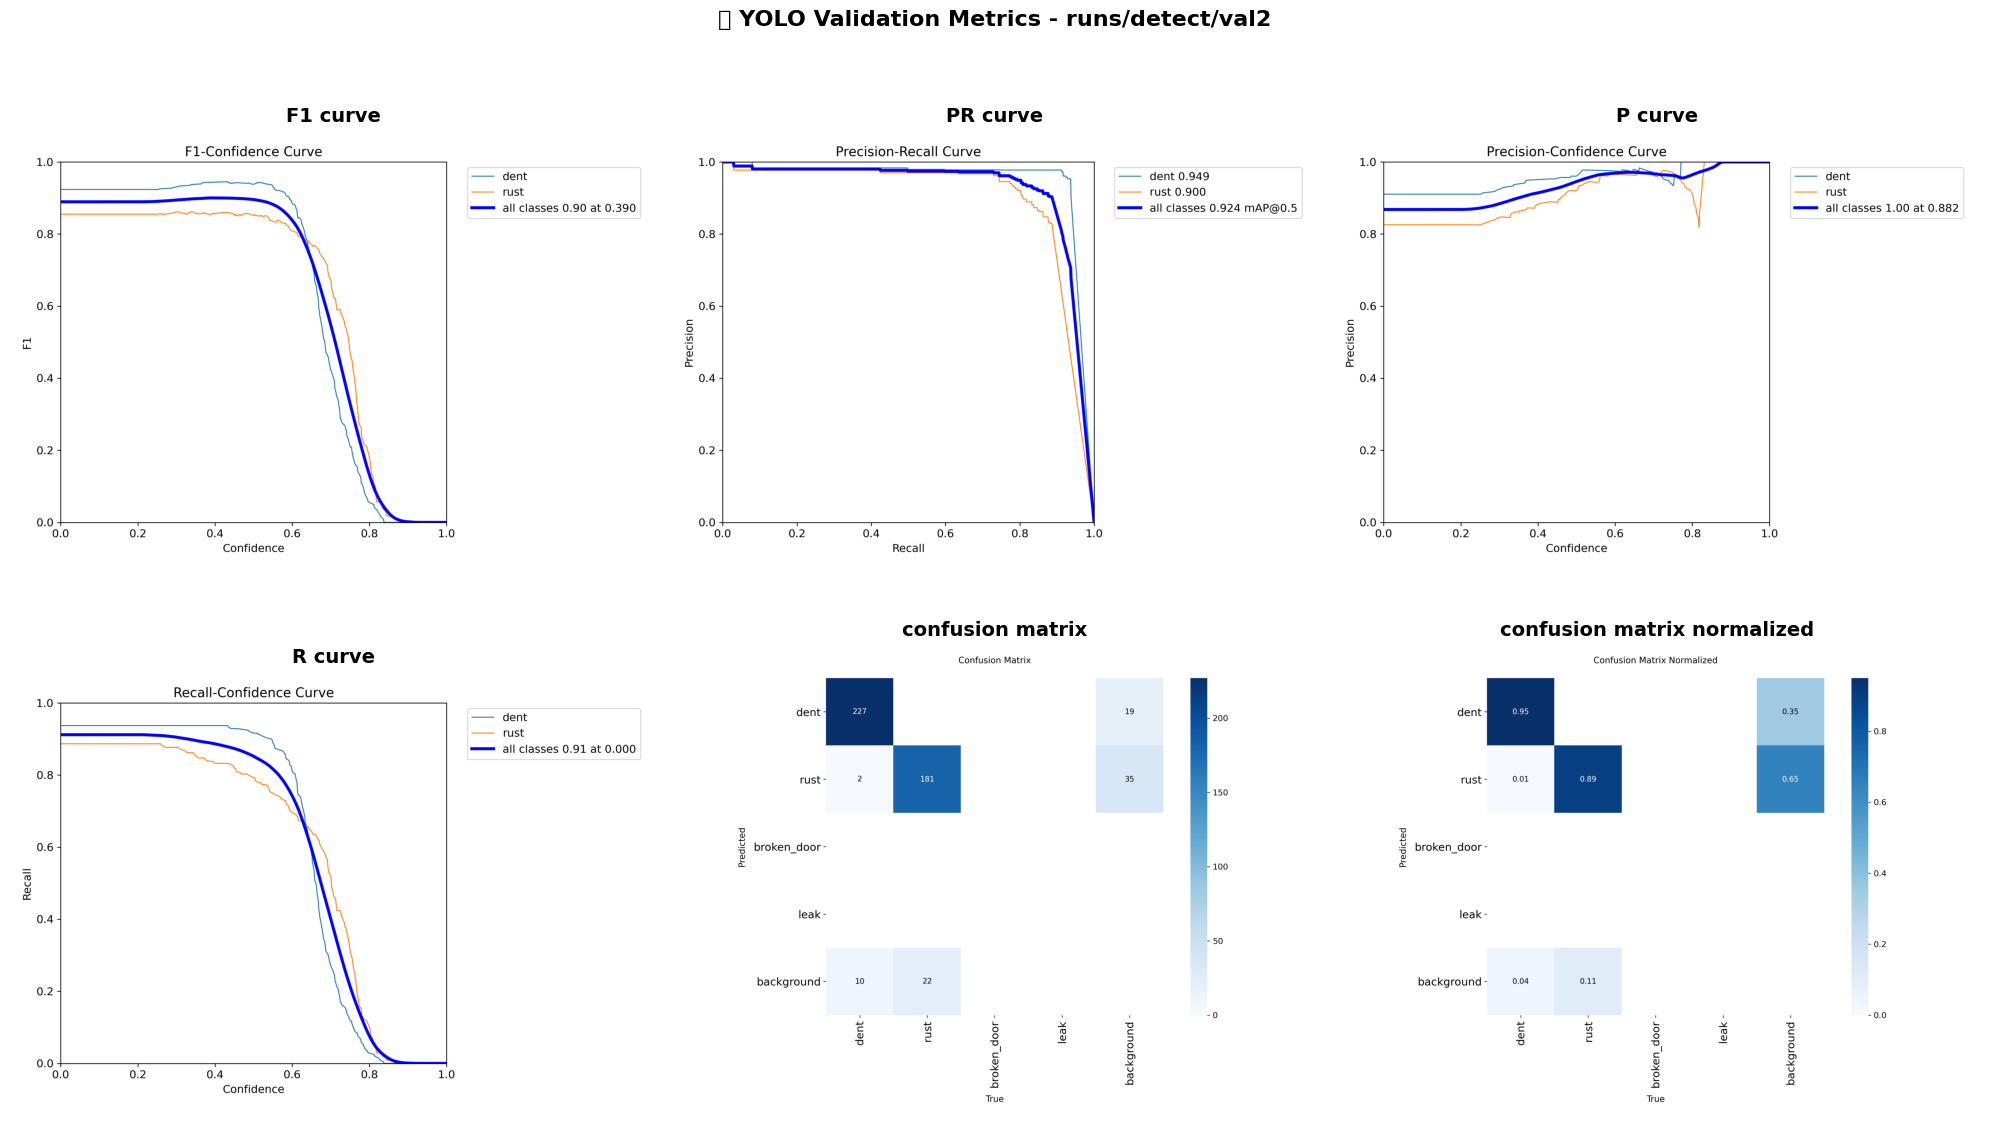


✅ Semua metrics dari: runs/detect/val2


In [20]:
# Tampilkan semua curve metrics dalam grid 2x3
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

latest_val = sorted(glob("runs/detect/val*"))[-1]

# Semua curve yang tersedia
all_curves = [
    "BoxF1_curve.png",
    "BoxPR_curve.png", 
    "BoxP_curve.png",
    "BoxR_curve.png",
    "confusion_matrix.png",
    "confusion_matrix_normalized.png"
]

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, curve_name in enumerate(all_curves):
    curve_path = os.path.join(latest_val, curve_name)
    
    if os.path.exists(curve_path):
        img = mpimg.imread(curve_path)
        axes[idx].imshow(img)
        
        # Buat title lebih readable
        title = curve_name.replace("Box", "").replace("_", " ").replace(".png", "")
        axes[idx].set_title(title, fontsize=14, fontweight='bold', pad=10)
        axes[idx].axis('off')

plt.suptitle(f"📊 YOLO Validation Metrics - {latest_val}", 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"\n✅ Semua metrics dari: {latest_val}")

---

## 📝 Catatan Penting

**Folder Struktur Validasi:**
- ✅ `runs/detect/val` → Hasil validasi pertama (original)
- ✅ `runs/detect/val2` → Hasil validasi dari model `train4` (CURRENT - berisi semua metrics)
- ❌ `runs/detect/val3` → Sudah diganti nama menjadi `val2`

**Training History:**
- `runs/detect/train` → Training pertama
- `runs/detect/train2` → Retraining ke-2
- `runs/detect/train3` → Retraining ke-3  
- `runs/detect/train4` → Retraining terbaru (CURRENT MODEL)

**Model Aktif Saat Ini:**
- **Path**: `runs/detect/train4/weights/best.pt`
- **mAP50**: 92.41%
- **Precision**: 91.14%
- **Recall**: 88.73%

---

In [23]:
import shutil
import os

# OPTIONAL: Copy model to models/ folder for backup
# Model dari train4 (model terbaru dengan performa terbaik)

SRC = "runs/detect/train4/weights/best.pt"  # Model terbaru dari train4
DST_DIR = "models"
DST = os.path.join(DST_DIR, "yolov8_container_damage.pt")

# Cek apakah backup model sudah ada
if os.path.exists(DST):
    print(f"✅ Model backup sudah ada di: {DST}")
    print(f"📂 Original model: {SRC}")
    print(f"\n💡 Tidak perlu copy lagi, model sudah tersimpan!")
    print(f"\n📍 Model locations:")
    print(f"   1. {SRC} (original - train4)")
    print(f"   2. {DST} (backup copy)")
elif os.path.exists(SRC):
    # Backup belum ada, copy model
    os.makedirs(DST_DIR, exist_ok=True)
    shutil.copy(SRC, DST)
    print(f"✅ Model berhasil di-backup ke: {DST}")
    print(f"📂 Original model: {SRC}")
    print(f"\n📍 Model saved in 2 locations:")
    print(f"   1. {SRC} (original - train4)")
    print(f"   2. {DST} (backup copy)")
else:
    print(f"⚠️ Model not found at {SRC}")
    print("   Jalankan training cell terlebih dahulu!")

✅ Model backup sudah ada di: models/yolov8_container_damage.pt
📂 Original model: runs/detect/train4/weights/best.pt

💡 Tidak perlu copy lagi, model sudah tersimpan!

📍 Model locations:
   1. runs/detect/train4/weights/best.pt (original - train4)
   2. models/yolov8_container_damage.pt (backup copy)


## 💾 Backup Model ke Folder `models/`

Cell di atas akan:
1. ✅ **Cek apakah backup sudah ada** - Jika sudah ada, tidak akan copy ulang (efisien!)
2. ✅ **Copy model dari train4** - Model terbaru dengan performa terbaik
3. ✅ **Simpan dengan nama deskriptif** - `yolov8_container_damage.pt`

**Keuntungan:**
- Tidak perlu copy berkali-kali jika model sudah di-backup
- Model tersimpan di folder `models/` yang mudah diakses
- Nama file lebih deskriptif daripada `best.pt`

In [21]:
import cv2
import numpy as np

# Define preprocessing function for YOLO inference
def preprocess(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (640, 640))
    img = img / 255.0  # Normalize to [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Test inference with trained model
test_img_path = "dataset/images/val/14_20220428T012931844Z_s00.mp4_37100.jpg"

# Use YOLO model directly (simpler than preprocess)
from ultralytics import YOLO
model = YOLO("runs/detect/train/weights/best.pt")

results = model.predict(source=test_img_path, conf=0.25)

print(f"✅ Detected {len(results[0].boxes)} objects")
print(f"Classes: {results[0].boxes.cls.tolist()}")
print(f"Confidences: {results[0].boxes.conf.tolist()}")


image 1/1 /Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/dataset/images/val/14_20220428T012931844Z_s00.mp4_37100.jpg: 640x384 2 dents, 1 rust, 42.2ms
Speed: 2.5ms preprocess, 42.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)
✅ Detected 3 objects
Classes: [0.0, 0.0, 1.0]
Confidences: [0.7859548926353455, 0.728325605392456, 0.7025140523910522]
image 1/1 /Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/dataset/images/val/14_20220428T012931844Z_s00.mp4_37100.jpg: 640x384 2 dents, 1 rust, 42.2ms
Speed: 2.5ms preprocess, 42.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)
✅ Detected 3 objects
Classes: [0.0, 0.0, 1.0]
Confidences: [0.7859548926353455, 0.728325605392456, 0.7025140523910522]


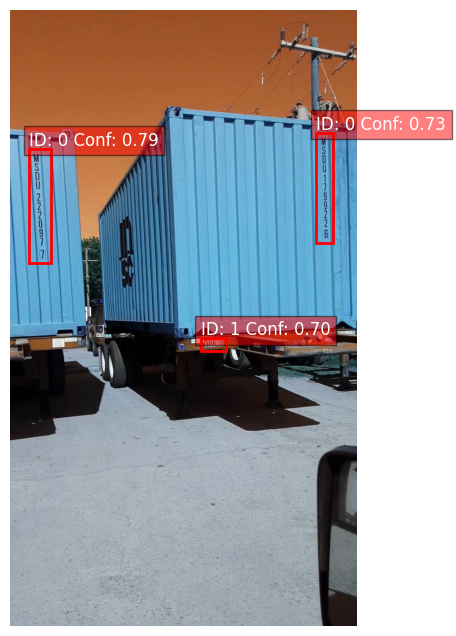

In [22]:
# Show results with image display in matplotplib

import matplotlib.pyplot as plt

def display_results(results):
    for result in results:
        img = result.orig_img
        boxes = result.boxes

        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        ax = plt.gca()

        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            cls = int(box.cls[0].cpu().numpy())

            rect = plt.Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                fill=False,
                color='red',
                linewidth=2
            )
            ax.add_patch(rect)
            ax.text(
                x1,
                y1 - 10,
                f"ID: {cls} Conf: {conf:.2f}",
                color='white',
                fontsize=12,
                bbox=dict(facecolor='red', alpha=0.5)
            )

        plt.axis('off')
        plt.show()

display_results(results)